## Part A Question 4

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
shap.initjs()


import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn import datasets
from sklearn.model_selection import KFold

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

In [5]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

## Question 4A

In [6]:
neg_voice_record_df = pd.read_csv('Q4_neg_voice_record.csv')
pos_voice_record_df = pd.read_csv('Q4_pos_voice_record.csv')
threshold = 0.5


In [7]:
neg_voice_record_df = neg_voice_record_df.drop(["filename"],axis = 1)
pos_voice_record_df = pos_voice_record_df.drop(["filename"], axis=1)

In [8]:
def process_dataset(df_train, df_test):
    
  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_test_scaled


neg_voice_record_df_scaled = process_dataset(X_train, neg_voice_record_df)
pos_voice_record_df_scaled = process_dataset(X_train, pos_voice_record_df)

## Question 4B 
**Do a model prediction on your sample test dataset with threshold = 0.5**

In [9]:
optimized_model = keras.models.load_model('optimized_model/')

neg_result_label = (optimized_model.predict(neg_voice_record_df_scaled)>threshold).astype("int32")
pos_result_label = (optimized_model.predict(pos_voice_record_df_scaled)>threshold).astype("int32")

data = {"Label": ["Negative Voice ", "Positive Voice"],"Result":[neg_result_label, pos_result_label]}


data_df = pd.DataFrame.from_dict(data)
data_df

1/1 [==============================] - 0s 18ms/step


,Label,Result
0,Negative Voice,[[0]]
1,Positive Voice,[[1]]


## Question 4C
#### Identify most important features using SHAP

In [10]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


#### Retrieve 1000 samples

In [11]:
X_train_sample = X_train_scaled[np.random.choice(len(X_train_scaled), 1000, replace=False)]
X_test_sample = X_test_scaled[np.random.choice(len(X_test_scaled), 1000, replace=False)]

In [12]:
model = keras.models.load_model('optimized_model/')
explainer = shap.DeepExplainer(model , X_train_sample)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


#### Force plot of neg voice record

In [13]:
shap_values = explainer.shap_values(neg_voice_record_df_scaled)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_test.columns)

#### Summary plot of neg voice record

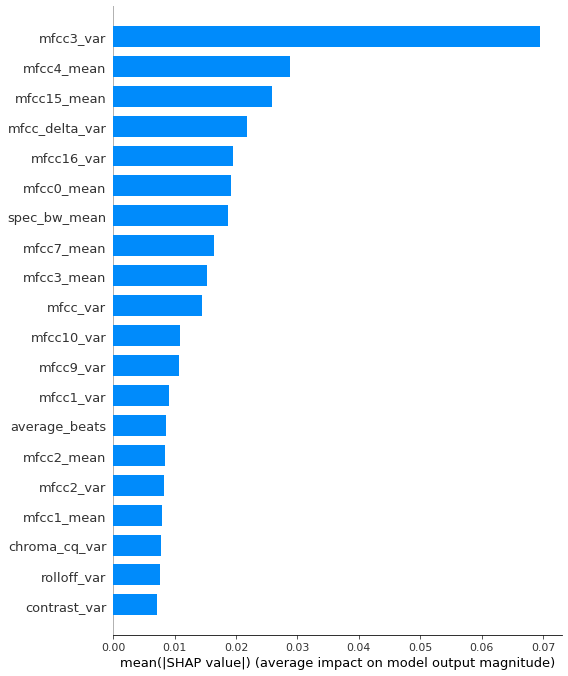

In [14]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

#### Force plot of pos voice record

In [15]:
shap_values = explainer.shap_values(pos_voice_record_df_scaled)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_test.columns)

#### Summary plot of pos voice record

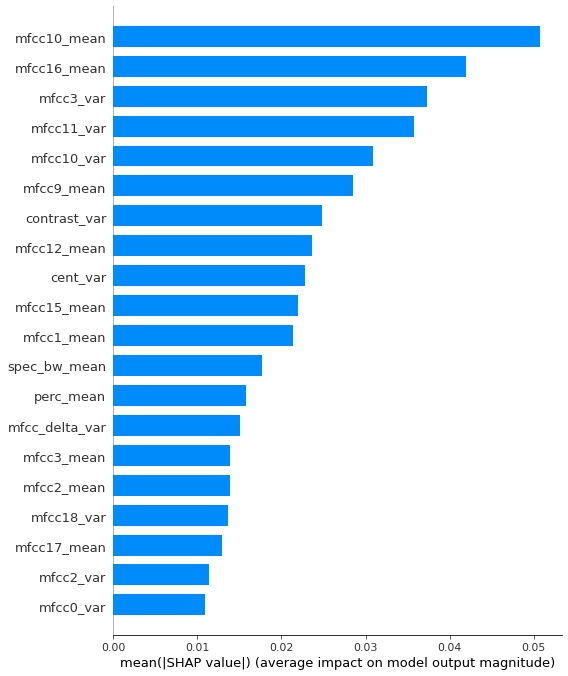

In [16]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

## Observation

**From the force plot of both the pos and neg_voice record, it shows the top most influential features that led to prediction value indicated. The red color features influence positivity(towards the predicted value) and the blue color influence negativity(away from the predicted value). With the force plot and summary, we can identify the magnitude of the features' impact to the resulting predicted value,**

#### Analysis on Positive/Negative Voice Record

**In the voice recording, we can identify that the features in red to be the most influential features in influencing the prediction to be closer to 1 (positive label) and in blue are the most influential features in influencing the predict to be closer to 0 (negative label)**

**From the summary plot, we can then identify the magnitude of the the features' impact to the resulting predicted value**

**In the positive voice recording, we can see that mfcc10_mean, mfcc16_mean are the top two most influential feature for a postive prediction and mfcc3_var along with mfcc11_var are the top two most influential feature for a negative prediction. This shows us that users can observe that given a certain value to a input feature, the user would be able to observe it would fare in its influence towards the prediction outcome.**

## Discussion Points

#### 1. Limitations of FFN

**FFN is prone to overfitting and with given large number of parameters, the model will be more complex and could take a long time to train. In addition, due to the risk of overfitting, the model may lose the ability to generalize to new examples.**

**Also, feed-forward neural networks may have results that are difficult to interpret due to the complexitiy of the model's architecture.**


#### 2. Most impactful parameter

**In terms of time taken for every epoch，the batch size is the most impactful parameter as from the table at Q2b, we notice that doubling the batch size shorterns the time taken for the final epoch significantly.**

**In terms of accuracy, the number of neurons in the first hidden layer is the most impactful paramater as from the table at Q3b, we notice that there is significant rise in accuracy when the number of neurons increases**

#### 3. Alternative approaches

**We can use CNN model architecture for genre classfication as well. Similar to the assignment, we have to perform feature extraction and define the model architecture. In fact, we can experiment by adding more hidden layers so that the model is able to handle more complex tasks and learn the relationships between features**

#### 4. Other dataset

**Analysing the audio waveforms to idenitify the species of the subject(animals). Perhaps more hidden layer is required for the model to learn the relationship between the features extracted from the audio of different species** 

**Also, we can do speech enhancement. To improve the quality of the audio, we would need a very large and complex and neural network model which would need an increase in hidden layers and number of units.**


#### 5. Neural Network Ensemble

**An ensemble of neural network can be done to achieve diversification in order to build models that can generalize better**

